In [ ]:
# 0) Imports
from sklearn.model_selection import train_test_split
import pandas as pd
from pandas.api.types import is_numeric_dtype
from matplotlib import pyplot as plt
import seaborn as sns
import torch as torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In [ ]:
# 1.1) Carga de la Base de Datos y Conversión de Variables
columns = ["age", "workclass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex",
           "capital-gain", "capital-loss", "hours-per-week",
           "native-country", "income"]

training_data = pd.read_csv("/adult.data", header = None, names = columns, na_values=[" ?"])
testing_data = pd.read_csv("/adult.test", header = None, skiprows = 1, names = columns, na_values=[" ?"])

print("Numero de filas:", training_data.shape[0])
cols_with_missing = training_data.isnull().any(axis=1).sum()
print("Numero de filas con missing values:", cols_with_missing)
print("Porcentaje de missing values sobre total:", round(100*cols_with_missing/training_data.shape[0], 2))
# Porcentaje no despreciable, pero no tan grande. Trade-Off: tamaño v.s. ruido

# Carga sin NaN
training_data = pd.read_csv("/adult.data", header = None, names = columns)
testing_data = pd.read_csv("/adult.test", header = None, skiprows = 1, names = columns)

# Quitar puntos finales
training_data["income"] = training_data["income"].str.strip().str.replace(".", "", regex=False)
testing_data["income"]  = testing_data["income"].str.strip().str.replace(".", "", regex=False)

# Mapear a binario: <=50K -> 0, >50K -> 1
training_data["income"] = training_data["income"].map({"<=50K": 0, ">50K": 1})
testing_data["income"]  = testing_data["income"].map({"<=50K": 0, ">50K": 1})

# Verificación
print(training_data["income"].unique())
print(testing_data["income"].unique())

# Detectar variables categóricas
categorical_cols = training_data.select_dtypes(include=["object"]).columns
numerical_cols = list(set(training_data.columns) - set(categorical_cols))

#  One-hot encoding
training_data = pd.get_dummies(training_data, columns=categorical_cols)
testing_data = pd.get_dummies(testing_data, columns=categorical_cols)
testinng_data = testing_data.reindex(columns=training_data.columns, fill_value=0)


Numero de filas: 32561
Numero de filas con missing values: 2399
Porcentaje de missing values sobre total: 7.37
[0 1]
[0 1]


In [ ]:
# 1.2) Segmentar los Datos
target = "income"

X_train = training_data.drop(target, axis=1)
y_train = training_data[[target]]

X_test = testing_data.drop(target, axis = 1)
y_test = testing_data[[target]]

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

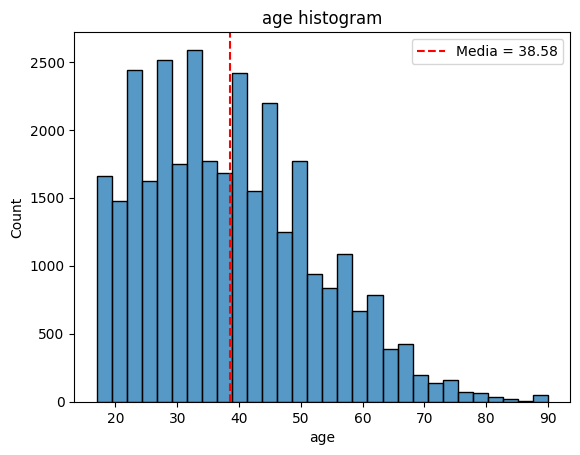

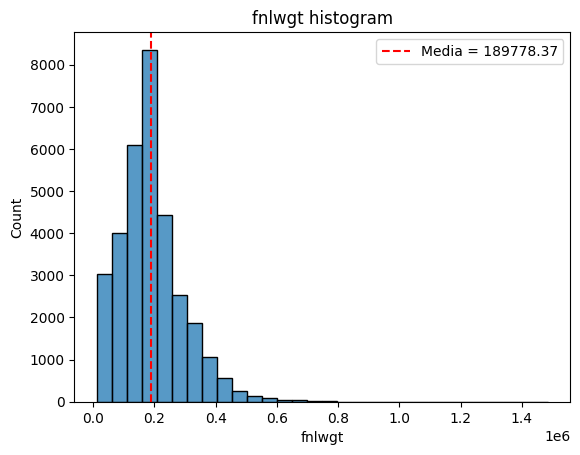

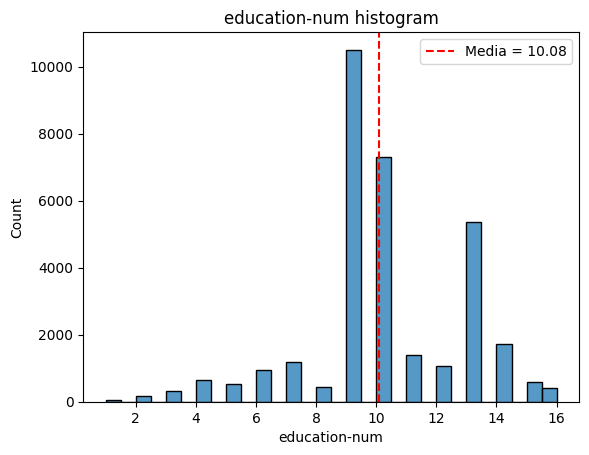

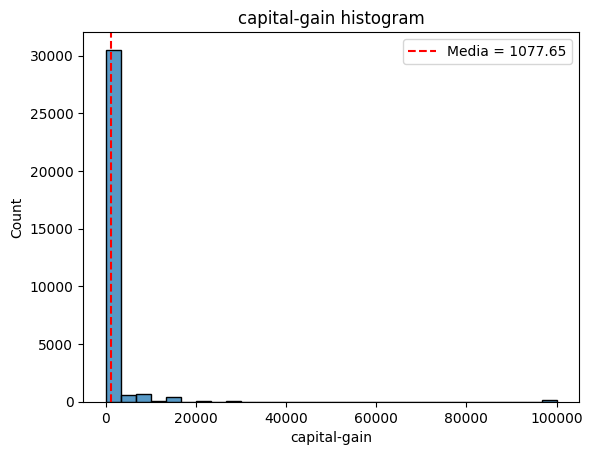

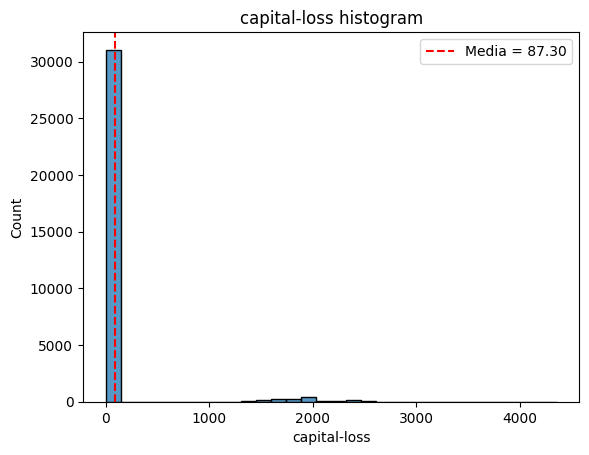

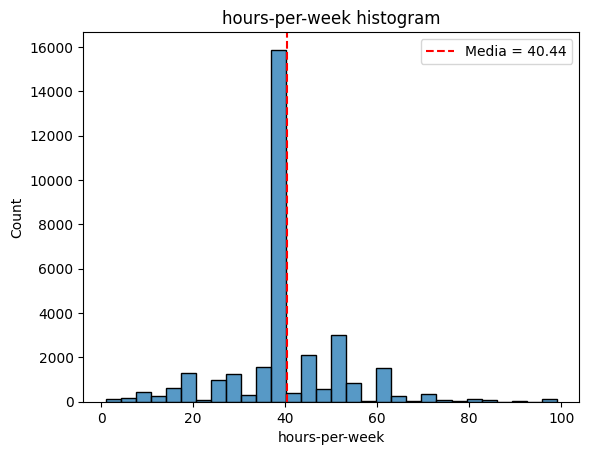

In [ ]:
# 1.3) Exploratory Data Analysis
for col in X_train.columns:
  if col in numerical_cols:
    sns.histplot(X_train[col], bins=30, kde=False)
    plt.axvline(X_train[col].mean(), color="red", linestyle="--", label=f"Media = {X_train[col].mean():.2f}")
    plt.title(f"{col} histogram")
    plt.legend()
    plt.show()

In [ ]:
# 1.4) Preprocessing
cols_to_scale = [col for col in numerical_cols]

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Estandarización
feature_scaler = StandardScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled =  feature_scaler.transform(X_test)

In [ ]:
# 2.1) Modelo Baseline
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_val_pred   = log_reg.predict(X_val_scaled)
y_test_pred  = log_reg.predict(X_test_scaled)

# Métricas por Segmento del Data Set
# Entrenamiento
print("Entrenamiento--------------------")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))
print("F1:", f1_score(y_train, y_train_pred))
print("ROC-AUC:", roc_auc_score(y_train, log_reg.predict_proba(X_train_scaled)[:,1]))
print(classification_report(y_train, y_train_pred))

# --- Validación ---
print("\nValidación--------------------")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1]))
print(classification_report(y_val, y_val_pred))

# --- Test ---
print("\Test--------------------")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:,1]))
print(classification_report(y_test, y_test_pred))


<>:29: SyntaxWarning: invalid escape sequence '\T'
<>:29: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-2879065883.py:29: SyntaxWarning: invalid escape sequence '\T'
  print("\Test--------------------")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Entrenamiento--------------------
Accuracy: 0.8533521697736556
Precision: 0.738339552238806
Recall: 0.6056625430429792
F1: 0.6654522525047292
ROC-AUC: 0.9088722837470784
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     24720
           1       0.74      0.61      0.67      7841

    accuracy                           0.85     32561
   macro avg       0.81      0.77      0.79     32561
weighted avg       0.85      0.85      0.85     32561


Validación--------------------
Accuracy: 0.8469475494411006
Precision: 0.710126582278481
Recall: 0.587434554973822
F1: 0.6429799426934097
ROC-AUC: 0.9004652468110385
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6231
           1       0.71      0.59      0.64      1910

    accuracy                           0.85      8141
   macro avg       0.80      0.76      0.77      8141
weighted avg       0.84      0.85      0.84      8141

\Test----

Usando dispositivo: cpu


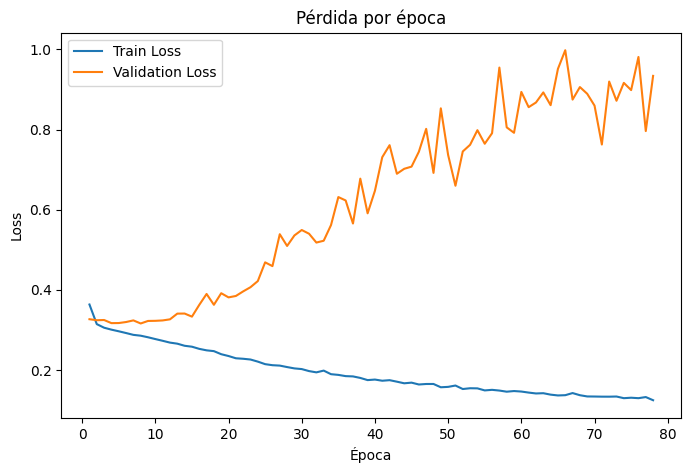

Métricas Entrenamiento:
Accuracy: 0.9480, Precision: 0.9076, Recall: 0.8731, F1: 0.8900, ROC-AUC: 0.9225
Métricas de Validación:
Accuracy: 0.8278, Precision: 0.6391, Recall: 0.6110, F1: 0.6247, ROC-AUC: 0.7526
Métricas test:
Accuracy: 0.8271, Precision: 0.6472, Recall: 0.6007, F1: 0.6231, ROC-AUC: 0.7493


In [ ]:
# 2.2) Red Neuronal

# Verificar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Si hay GPU, mostrar información
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

# Creación de Arquitectura
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_neurons, output_size, dropout_prob=0.0):
        super(MLP, self).__init__()
        layers = []
        # Primera capa
        layers.append(nn.Linear(input_size, hidden_neurons))
        layers.append(nn.ReLU())
        # Regularización
        if dropout_prob > 0:
            layers.append(nn.Dropout(dropout_prob))
        # Capas ocultas
        for i in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            layers.append(nn.ReLU())

            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
        # Capa de salida (sin función de activación)
        layers.append(nn.Linear(hidden_neurons, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

# Hiperparámetros
input_size = X_train_scaled.shape[1]
hidden_layers = 6
hidden_neurons = 120
learning_rate = 0.001
batch_size = 90
num_epochs = 78

# Instanciar el modelo y moverlo a GPU
model = MLP(input_size=input_size,
            hidden_layers=hidden_layers,
            hidden_neurons=hidden_neurons,
            output_size=1).to(device)

# Definir función de pérdida
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Crear datasets
y_train_tensor = torch.Tensor(y_train.values).float()
y_val_tensor   = torch.Tensor(y_val.values).float()
y_test_tensor  = torch.Tensor(y_test.values).float()

train_dataset = TensorDataset(torch.Tensor(X_train_scaled), y_train_tensor)
val_dataset   = TensorDataset(torch.Tensor(X_val_scaled), y_val_tensor)
test_dataset  = TensorDataset(torch.Tensor(X_test_scaled), y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Loop de entrenamiento
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        # Mover datos a GPU
        batch_x = batch_x.to(device)  # ← MOVER BATCH A GPU
        batch_y = batch_y.to(device)  # ← MOVER BATCH A GPU

        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + (loss.item() * batch_x.size(0))
    train_loss = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Mover datos a GPU
            batch_x = batch_x.to(device)  # ← MOVER BATCH A GPU
            batch_y = batch_y.to(device)  # ← MOVER BATCH A GPU

            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            val_loss = val_loss + (loss.item() * batch_x.size(0))
    val_loss = val_loss / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida por época")
plt.legend()
plt.show()

# ------------------------
# Métricas para entrenamiento
# ------------------------
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_true_all.append(batch_y.cpu())
        y_pred_all.append(preds.cpu())

y_true_all = torch.cat(y_true_all).numpy()
y_pred_all = torch.cat(y_pred_all).numpy()

accuracy_train = accuracy_score(y_true_all, y_pred_all)
precision_train = precision_score(y_true_all, y_pred_all)
recall_train = recall_score(y_true_all, y_pred_all)
f1_train = f1_score(y_true_all, y_pred_all)
roc_auc_train = roc_auc_score(y_true_all, y_pred_all)

print("Métricas Entrenamiento:")
print(f"Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}, ROC-AUC: {roc_auc_train:.4f}")

# ------------------------
# Métricas para validación
# ------------------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_true_all.append(batch_y.cpu())
        y_pred_all.append(preds.cpu())

y_true_all = torch.cat(y_true_all).numpy()
y_pred_all = torch.cat(y_pred_all).numpy()

accuracy_val = accuracy_score(y_true_all, y_pred_all)
precision_val = precision_score(y_true_all, y_pred_all)
recall_val = recall_score(y_true_all, y_pred_all)
f1_val = f1_score(y_true_all, y_pred_all)
roc_auc_val = roc_auc_score(y_true_all, y_pred_all)

print("Métricas de Validación:")
print(f"Accuracy: {accuracy_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1: {f1_val:.4f}, ROC-AUC: {roc_auc_val:.4f}")


# ------------------------
# Métricas para prueba
# ------------------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_true_all.append(batch_y.cpu())
        y_pred_all.append(preds.cpu())

y_true_all = torch.cat(y_true_all).numpy()
y_pred_all = torch.cat(y_pred_all).numpy()

accuracy_test = accuracy_score(y_true_all, y_pred_all)
precision_test = precision_score(y_true_all, y_pred_all)
recall_test = recall_score(y_true_all, y_pred_all)
f1_test = f1_score(y_true_all, y_pred_all)
roc_auc_test = roc_auc_score(y_true_all, y_pred_all)

print("Métricas test:")
print(f"Accuracy: {accuracy_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1: {f1_test:.4f}, ROC-AUC: {roc_auc_test:.4f}")

Usando dispositivo: cpu
Early stopping en época 12


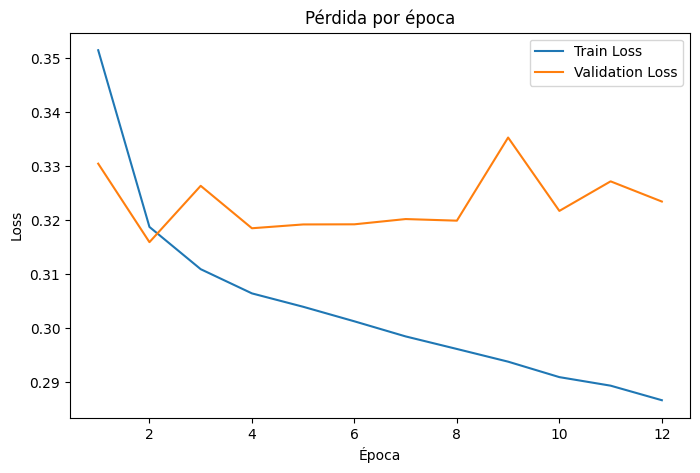

Métricas entrenamiento:
Accuracy: 0.8752, Precision: 0.7955, Recall: 0.6485, F1: 0.7145, ROC-AUC: 0.7978
Métricas de Validación:
Accuracy: 0.8509, Precision: 0.7254, Recall: 0.5864, F1: 0.6485, ROC-AUC: 0.7592
Métricas Test:
Accuracy: 0.8549, Precision: 0.7425, Recall: 0.5971, F1: 0.6619, ROC-AUC: 0.7662


In [ ]:
# 2.5) Red Neuronal con DropOut y EarlyStopping

# Verificar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Si hay GPU, mostrar información
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

# Creación de Arquitectura
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_neurons, output_size, dropout_prob=0.0):
        super(MLP, self).__init__()
        layers = []
        # Primera capa
        layers.append(nn.Linear(input_size, hidden_neurons))
        layers.append(nn.ReLU())
        # Regularización
        if dropout_prob > 0:
            layers.append(nn.Dropout(dropout_prob))
        # Capas ocultas
        for i in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            layers.append(nn.ReLU())

            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
        # Capa de salida (sin función de activación)
        layers.append(nn.Linear(hidden_neurons, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

torch.manual_seed(45)
if torch.cuda.is_available():
    torch.cuda.manual_seed(45)

# Hiperparámetros
input_size = X_train_scaled.shape[1]
hidden_layers = 4
hidden_neurons = 256
learning_rate = 0.001
batch_size = 64
num_epochs = 100
dropout_prob = 0.2

# Instanciar el modelo y moverlo a GPU
model = MLP(input_size=input_size,
            hidden_layers=hidden_layers,
            hidden_neurons=hidden_neurons,
            output_size=1, dropout_prob = dropout_prob).to(device)

# Definir función de pérdida
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Crear datasets
y_train_tensor = torch.Tensor(y_train.values).float()
y_val_tensor   = torch.Tensor(y_val.values).float()
y_test_tensor  = torch.Tensor(y_test.values).float()

train_dataset = TensorDataset(torch.Tensor(X_train_scaled), y_train_tensor)
val_dataset   = TensorDataset(torch.Tensor(X_val_scaled), y_val_tensor)
test_dataset  = TensorDataset(torch.Tensor(X_test_scaled), y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Loop de entrenamiento
train_losses = []
val_losses = []

patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        # Mover datos a GPU
        batch_x = batch_x.to(device)  # ← MOVER BATCH A GPU
        batch_y = batch_y.to(device)  # ← MOVER BATCH A GPU

        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + (loss.item() * batch_x.size(0))
    train_loss = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            # Mover datos a GPU
            batch_x = batch_x.to(device)  # ← MOVER BATCH A GPU
            batch_y = batch_y.to(device)  # ← MOVER BATCH A GPU

            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            val_loss = val_loss + (loss.item() * batch_x.size(0))
    val_loss = val_loss / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping en época {epoch+1}")
            model.load_state_dict(best_model_state)
            break

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida por época")
plt.legend()
plt.show()

# ------------------------
# Métricas para entrenamiento
# ------------------------
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_true_all.append(batch_y.cpu())
        y_pred_all.append(preds.cpu())

y_true_all = torch.cat(y_true_all).numpy()
y_pred_all = torch.cat(y_pred_all).numpy()

accuracy_train = accuracy_score(y_true_all, y_pred_all)
precision_train = precision_score(y_true_all, y_pred_all)
recall_train = recall_score(y_true_all, y_pred_all)
f1_train = f1_score(y_true_all, y_pred_all)
roc_auc_train = roc_auc_score(y_true_all, y_pred_all)

print("Métricas entrenamiento:")
print(f"Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}, ROC-AUC: {roc_auc_train:.4f}")


# ------------------------
# Métricas para validación
# ------------------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_true_all.append(batch_y.cpu())
        y_pred_all.append(preds.cpu())

y_true_all = torch.cat(y_true_all).numpy()
y_pred_all = torch.cat(y_pred_all).numpy()

accuracy_val = accuracy_score(y_true_all, y_pred_all)
precision_val = precision_score(y_true_all, y_pred_all)
recall_val = recall_score(y_true_all, y_pred_all)
f1_val = f1_score(y_true_all, y_pred_all)
roc_auc_val = roc_auc_score(y_true_all, y_pred_all)

print("Métricas de Validación:")
print(f"Accuracy: {accuracy_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1: {f1_val:.4f}, ROC-AUC: {roc_auc_val:.4f}")


# ------------------------
# Métricas para prueba
# ------------------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        y_true_all.append(batch_y.cpu())
        y_pred_all.append(preds.cpu())

y_true_all = torch.cat(y_true_all).numpy()
y_pred_all = torch.cat(y_pred_all).numpy()

accuracy_test = accuracy_score(y_true_all, y_pred_all)
precision_test = precision_score(y_true_all, y_pred_all)
recall_test = recall_score(y_true_all, y_pred_all)
f1_test = f1_score(y_true_all, y_pred_all)
roc_auc_test = roc_auc_score(y_true_all, y_pred_all)

print("Métricas Test:")
print(f"Accuracy: {accuracy_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1: {f1_test:.4f}, ROC-AUC: {roc_auc_test:.4f}")